In [1]:
import pandas as pd
import numpy as np
import os
import collections
import seaborn as sns
import matplotlib.pyplot as plt

import torch

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

In [2]:
# Get State case series
def getStateData(file, state, begin_period, end_period, threshold=None, fips=None): 
    """
    Input:
        file: filename (csv)
        state: full name of a US State
        bp: begin date
        end_period: end date
        threshhold: minimum total new cases
    
    Output:
        Create {state}_{len(conuties)}_counties_{days}.txt.
        Data and a list of county fips.
    """
    df = pd.read_csv(file)
    df = df.dropna(subset=['fips'])
    df["fips"] = df["fips"].astype(int)
    df = df[df["state"]==state]
    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= begin_period) & (df["date"] <= end_period)]
    
    df_counties = df[["date", "fips", "cases"]]
    
    if fips:
        df_counties = df_counties[fips]
        
    df_counties = df_counties.pivot_table(index='date', columns=["fips"], aggfunc=np.sum)
    df_counties.columns = df_counties.columns.droplevel()
    df_counties = df_counties.reset_index()

    # Get new cases
    df_counties_new_cases = df_counties.iloc[1:].reset_index() - df_counties.iloc[:-1].reset_index()
    df_counties_new_cases = df_counties_new_cases.drop(["index", "date"], axis=1)

    # Clean outliers
    df_counties_new_cases = df_counties_new_cases.dropna(axis=1)
    if threshold:
        df_counties_new_cases = df_counties_new_cases.loc[:, (df_counties_new_cases.sum()>threshold).values]

    # Data and relevant info
    counties = list(df_counties_new_cases.columns)
    data = df_counties_new_cases.values
    days = df_counties_new_cases.shape[0]

    # Save data as txt (csv)
#     np.savetxt(f'{data_path}/{STATES[state]}_{len(counties)}_counties_{days}.txt', data, delimiter=",", fmt="%.1f")
    
    return data, counties

In [168]:
# Get 50 States of U.S
df = pd.read_csv("us-counties.txt")
states = list(set(df["state"]))
states.sort()
print(states)
STATES = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 
          'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 
          'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 
          'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 
          'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 
          'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 
          'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 
          'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 
          'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 
          'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 
          'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}
print(len(STATES))

['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
50


In [169]:
# Make series file containing all U.S. counties above a threshold
data_path = "state_data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

begin_period = "2020-04-06" # We predict new cases, so first day is not included in predictions
end_period = "2021-10-06"
file = "us-counties.txt"
threshold = 10000
# thresold = 3000

data_by_state = []
county_by_state = []
for state in STATES:
    data, counties = getStateData(file, state, begin_period, end_period, threshold)
    data_by_state.append(data)
    county_by_state.append(counties)
    print(f'{state}: {len(counties)} counties ------ DONE')

# Combine and save U.S. data
us_data = np.hstack(data_by_state)
COUNTIES = np.hstack(county_by_state)
days = us_data.shape[0]
np.savetxt(f'{data_path}/US_{len(COUNTIES)}_counties_{days}.txt', us_data, delimiter=",", fmt="%.1f")

print(len(data_by_state))
print(len(COUNTIES)) 

Alabama: 21 counties ------ DONE
Alaska: 3 counties ------ DONE
Arizona: 10 counties ------ DONE
Arkansas: 13 counties ------ DONE
California: 36 counties ------ DONE
Colorado: 11 counties ------ DONE
Connecticut: 8 counties ------ DONE
Delaware: 3 counties ------ DONE
Florida: 41 counties ------ DONE
Georgia: 37 counties ------ DONE
Hawaii: 2 counties ------ DONE
Idaho: 6 counties ------ DONE
Illinois: 23 counties ------ DONE
Indiana: 24 counties ------ DONE
Iowa: 10 counties ------ DONE
Kansas: 7 counties ------ DONE
Kentucky: 13 counties ------ DONE
Louisiana: 18 counties ------ DONE
Maine: 3 counties ------ DONE
Maryland: 12 counties ------ DONE
Massachusetts: 10 counties ------ DONE
Michigan: 23 counties ------ DONE
Minnesota: 12 counties ------ DONE
Mississippi: 12 counties ------ DONE
Missouri: 16 counties ------ DONE
Montana: 5 counties ------ DONE
Nebraska: 3 counties ------ DONE
Nevada: 2 counties ------ DONE
New Hampshire: 4 counties ------ DONE
New Jersey: 20 counties -----

In [6]:
# TODO Make CA data with longer time range
data_path = "state_data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

begin_period = "2020-04-06" # We predict new cases, so first day is not included in predictions
end_period = "2021-10-06"
file = "us-counties.txt"
state = 'California'

data, counties = getStateData(file, state, begin_period, end_period, threshold=3000)
print(len(counties))
print(counties)

48
[6001, 6005, 6007, 6009, 6013, 6015, 6017, 6019, 6021, 6023, 6025, 6029, 6031, 6033, 6037, 6039, 6041, 6045, 6047, 6053, 6055, 6057, 6059, 6061, 6065, 6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093, 6095, 6097, 6099, 6101, 6103, 6107, 6109, 6111, 6113, 6115]


In [ ]:
print(us_data.shape)

In [170]:
# Read county adjacency file. Make county to fips dict and adjacency list.
county_adj = pd.read_csv("../county_adjacency2010.csv")

adj_info = county_adj[['fipscounty', 'fipsneighbor']]
us_adj = collections.defaultdict(list)
for _, row in adj_info.iterrows():
    us_adj[row['fipscounty']].append(row['fipsneighbor'])

# us_adj: {fips: [neighber fips]}

In [150]:
# Get geographic adjacency data given a list of fips
def getAdjData(fips, file=us_adj, state=None):
    """
    Input:
        fips: list of fips
        file: dictionary containing the adj data
        state: whole us by default
        
    Output:
        Create {state}_{len(fips)}_counties-adj.txt
    """
    n = len(fips)
    adj_g = np.zeros((n, n))

    for fip in fips:
        neighbors = us_adj[fip]
        for neighbor in neighbors:
            if neighbor in fips:
                i, j = fips_to_idx[fip], fips_to_idx[neighbor]
                adj_g[i, j] = 1
           
    filename = f'{data_path}/US_{n}_counties-adj.txt'
    if state:
        filename = f'{data_path}/{state}_{n}_counties-adj.txt'

    np.savetxt(filename, adj_g, delimiter=",", fmt="%d")
    return

In [171]:
# Make US adj_g
data_path = "state_adj/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

fips_to_idx = {f: i for i, f in enumerate(COUNTIES)}

getAdjData(COUNTIES)

# # Make adj_g for each state
# for state, fips in zip(STATES, county_by_state):
#     fips_to_idx = {f: i for i, f in enumerate(fips)}
#     getAdjData(fips, state=STATES[state])
#     print(f'{state}: {len(fips)} counties ------ DONE')

In [153]:
# Get SCI data given a list of fips
def getSCIData(fips, file=us_sci, state=None):
    """
    Input:
        fips: list of fips
        file: dataframe containing all the SCI data
        state: whole us by default
        
    Output:
        Create {state}_{len(fips)}_counties-sci.txt
    """
    df = us_sci
    df_filtered = df[(df['user_loc'].isin(fips)) & (df['fr_loc'].isin(fips)) & (df['fr_loc'] >= df['user_loc'])]
    
    n = len(fips)
    SCI = np.zeros((n, n))

    for _, row in df_filtered.iterrows():
        i = fips_to_idx[row['user_loc']]
        j = fips_to_idx[row['fr_loc']]
        SCI[i, j] = row['scaled_sci']
        SCI[j, i] = row['scaled_sci']
                
    filename = f'{data_path}/US_{n}_counties-sci.txt'
    if state:
        filename = f'{data_path}/{state}_{n}_counties-sci.txt'

    np.savetxt(filename, SCI, delimiter=",", fmt="%.1f")
    return

In [172]:
# Make US sci
us_sci = pd.read_csv("../county_county.tsv", sep='\t')

data_path = "state_sci/"
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
fips_to_idx = {f: i for i, f in enumerate(COUNTIES)}

getSCIData(COUNTIES)

# # Make SCI for each state
# for state, fips in zip(STATES, county_by_state):
#     fips_to_idx = {f: i for i, f in enumerate(fips)}
#     getSCIData(fips, state=STATES[state])
#     print(f'{state}: {len(fips)} counties ------ DONE')

In [173]:
# Save county information
with open("753_Counties.txt", 'w') as output:
    for counties in county_by_state:
        output.write(str(counties) + '\n')

In [179]:
data_path = "state_data/"
us_548 = np.loadtxt(data_path+"US_753_counties_548.txt", delimiter=",",)
us_365 = us_548[:365, :]
print(us_365.shape)
np.savetxt(data_path+"US_753_counties_365.txt", us_365, delimiter=",", fmt="%.1f")

(365, 753)


In [364]:
# Make SVI disctance matrix given a list of fips
def computeSVIAdj(fips, us_svi, state=None):
    """
    Input:
        fips: list of fips
        us_svi: raw SVI dataframe (pd) with selected features
        state: whole us by default
        
    Output:
        Create {state}_{len(fips)}_counties-svi.txt
    """
    n = len(fips)
    df = us_svi
    df = df[df['FIPS'].isin(fips)]
    df = df.sort_values('FIPS')
    df = df.drop(columns=['FIPS'])
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    distances = pdist(df_scaled, metric='euclidean')
    dist_matrix = squareform(distances)
#     dist_matrix = len(df.columns) - dist_matrix
    dist_matrix = 1 - dist_matrix / len(df.columns)
    
    filename = f'{data_path}/US_{n}_counties-svi.txt'
    if state:
        filename = f'{data_path}/{state}_{n}_counties-svi_new.txt'
    
    np.savetxt(filename, dist_matrix, delimiter=",", fmt="%.4f")
    return

In [365]:
# SVI data
df = pd.read_csv("../SVI2020_US_COUNTY.csv")

features = ['FIPS', 'AREA_SQMI', 'E_TOTPOP', 'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
           'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE',
            'EP_CROWD','EP_NOVEH', 'EP_GROUPQ']

df = df[features]
df['E_POPDEN'] = df['E_TOTPOP'] / df['AREA_SQMI']
us_svi = df.drop(columns=['AREA_SQMI'])

In [366]:
# Create U.S. SVI distance matrix
data_path = "state_svi/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

print(len(COUNTIES))
computeSVIAdj(COUNTIES, us_svi)

# Make SVI for CA
state = 'California'
fips = [6001, 6005, 6007, 6009, 6013, 6015, 6017, 6019, 6021, 6023, 6025, 6029, 6031, 6033, 6037, 6039, 6041, 6045, 6047, 6053, 6055, 6057, 6059, 6061, 6065, 6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093, 6095, 6097, 6099, 6101, 6103, 6107, 6109, 6111, 6113, 6115]

computeSVIAdj(fips, us_svi, state=STATES[state])
print(f'{state}: {len(fips)} counties ------ DONE')

753
California: 48 counties ------ DONE


In [336]:
# Get CA 48 County names
ca_fips = [6001, 6005, 6007, 6009, 6013, 6015, 6017, 6019, 6021, 6023, 6025, 6029, 6031, 6033, 6037, 6039, 6041, 6045, 6047, 6053, 6055, 6057, 6059, 6061, 6065, 6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093, 6095, 6097, 6099, 6101, 6103, 6107, 6109, 6111, 6113, 6115]
ca_counties = []

df = pd.read_csv("../fips-by-state.csv", encoding= 'unicode_escape')
df["fips"] = df["fips"].astype(int)
df = df[df["state"]=="CA"]
df = df.drop(columns=["state"])
fips_to_cname = {}
for _, row in df.iterrows():
    fips_to_cname[row['fips']] = row['name']
    
ca_counties = [fips_to_cname[fips][:-7] for fips in ca_fips]
print(ca_counties)

['Alameda', 'Amador', 'Butte', 'Calaveras', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Kern', 'Kings', 'Lake', 'Los Angeles', 'Madera', 'Marin', 'Mendocino', 'Merced', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']


In [377]:
# Visualize Adj, SCI, and SVI matrices.
adj_geo = torch.from_numpy(np.loadtxt("state_adj/CA_48_counties-adj.txt", delimiter=","))
adj_sci = torch.from_numpy(np.loadtxt("state_sci/CA_48_counties-sci.txt", delimiter=","))
adj_svi = torch.from_numpy(np.loadtxt("state_svi/CA_48_counties-svi_new.txt", delimiter=","))
adj_svi_2 = torch.from_numpy(np.loadtxt("state_svi/CA_48_counties-svi.txt", delimiter=","))

def NormalizeAdj(adj):
    rowsum = 1. / torch.sqrt(adj.sum(dim=0)) # 1/sqrt(degree)
    normalized_adj = rowsum[:, np.newaxis] * adj * rowsum[np.newaxis, :]
    return normalized_adj

a = NormalizeAdj(adj_svi)
b = NormalizeAdj(adj_svi_2)
print(torch.sum(a-b))

adj_geo = NormalizeAdj(adj_geo)
adj_sci = NormalizeAdj(adj_sci)
adj_svi = NormalizeAdj(adj_svi)

cmap = "Blues"
fs = 20
# cmap = None

# plt.figure(0, figsize=(12, 10))
# sns.heatmap(adj_geo, cmap=cmap)
# plt.title("Geolocation", fontsize=fs)
# plt.savefig("ca_geo.png")
# plt.show()

# plt.figure(1, figsize=(12, 10))
# sns.heatmap(adj_sci, cmap=cmap)
# plt.title("SCI", fontsize=fs)
# plt.savefig("ca_sci.png")
# plt.show()

# plt.figure(2, figsize=(12, 10))
# sns.heatmap(adj_svi, cmap=cmap)
# plt.title("SVI", fontsize=fs)
# plt.savefig("ca_svi.png")
# plt.show()

tensor(-1.1841e-07, dtype=torch.float64)


[ 123.   31.   56.   16.  150.   18.   21.  292.    0.   43.   43.  453.
   47.   16. 1455.   57.   16.   25.   55.   29.   27.   13.  384.   98.
  537.  224.    4.  293.  669.   28.   78.   23.   50.   10.  131.   23.
  115.   18.   57.   36.  113.    9.   22.  136.   36.  181.   21.   47.]
[ 1.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
  1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  1.000e+00  0.000e+00  0.000e+00  1.000e+00  1.000e+00
  0.000e+00  0.000e+00 -1.000e+00  0.000e+00  2.000e+00  0.000e+00
  0.000e+00  2.000e+00  0.000e+00  0.000e+00  0.000e+00  2.000e+00
  2.000e+00  4.000e+00  1.000e+00  3.000e+00  0.000e+00  0.000e+00
  1.000e+00  5.000e+00  0.000e+00  0.000e+00  4.000e+00  0.000e+00
  0.000e+00  7.000e+00  0.000e+00  4.000e+00  5.000e+00  5.000e+00
  0.000e+00  0.000e+00  3.000e+00  3.

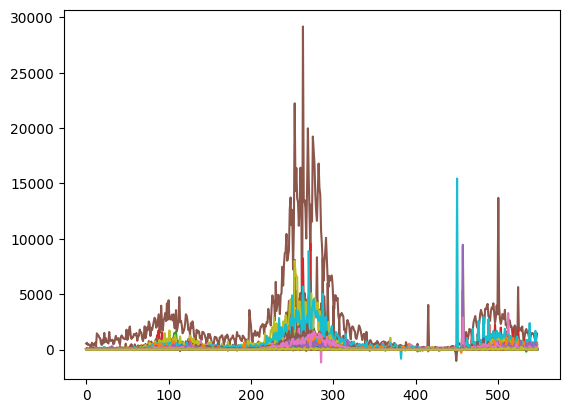

In [385]:
# Case data statistics
mts = np.loadtxt("state_data/CA_48_counties_548.txt", delimiter=",")
print(mts[-1])
plt.figure(0)
print(mts[:, 2])
plt.plot(mts[:, 2])
for i in range(mts.shape[1]):
    plt.plot(mts[:, i])
plt.show()
# print(torch.argmax(mts[0]), torch.argmin(mts[0]))
# print(COUNTIES[484])
# print(mts)

In [346]:
# Make SCI
df = pd.read_csv("../county_county.tsv", sep='\t')
df_filtered = df[(df['user_loc'].isin(fips)) & (df['fr_loc'].isin(fips)) & (df['fr_loc'] >= df['user_loc'])]

n = len(counties)
SCI = np.ones((n, n))

for _, row in df_filtered.iterrows():
    i = fips_to_idx[row['user_loc']]
    j = fips_to_idx[row['fr_loc']]
    SCI[i, j] = row['scaled_sci']
    SCI[j, i] = row['scaled_sci']
print(SCI)
np.savetxt("ga_counties-91-sci.txt", SCI, delimiter=",", fmt="%.1f")

KeyError: 6001

In [132]:
# SVI data
df = pd.read_csv("../SVI2020_US_COUNTY.csv")

# features = ['FIPS', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'E_POV150', 'E_UNEMP', 'E_HBURD', 'E_NOHSDP', 'E_UNINSUR',
#            'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT', 'E_MOBILE', 'E_CROWD',
#            'E_NOVEH', 'E_GROUPQ']

features = ['FIPS', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
           'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE',
            'EP_CROWD','EP_NOVEH', 'EP_GROUPQ']

df = df[features]
df = df[df['FIPS'].isin(fips)]
df = df.sort_values('FIPS')
df['E_POPDEN'] = df['E_TOTPOP'] / df['AREA_SQMI']

# df.to_csv("ca_counties-47-svi.csv", index=False)

# data = pd.read_csv("ca_counties-47-svi.csv")
print(df.columns)

Index(['FIPS', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150',
       'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'E_POPDEN'],
      dtype='object')


            AREA_SQMI  E_TOTPOP      E_HU      E_HH  EP_POV150  EP_UNEMP  \
AREA_SQMI    1.000000  0.027603  0.023901  0.022226   0.034170  0.153017   
E_TOTPOP     0.027603  1.000000  0.994018  0.995987  -0.121818  0.030292   
E_HU         0.023901  0.994018  1.000000  0.999002  -0.125269  0.032586   
E_HH         0.022226  0.995987  0.999002  1.000000  -0.128726  0.028733   
EP_POV150    0.034170 -0.121818 -0.125269 -0.128726   1.000000  0.558046   
EP_UNEMP     0.153017  0.030292  0.032586  0.028733   0.558046  1.000000   
EP_HBURD    -0.015246  0.298875  0.314805  0.306906   0.247127  0.281108   
EP_NOHSDP   -0.014164 -0.044205 -0.059177 -0.059079   0.655934  0.374666   
EP_UNINSUR   0.130211 -0.049643 -0.058547 -0.061260   0.442278  0.250759   
EP_AGE65    -0.067394 -0.207974 -0.196660 -0.205422  -0.032287 -0.125708   
EP_AGE17     0.105691  0.031529  0.010508  0.018547   0.098380  0.057335   
EP_DISABL   -0.035231 -0.228974 -0.228143 -0.232407   0.530183  0.343873   
EP_SNGPNT   

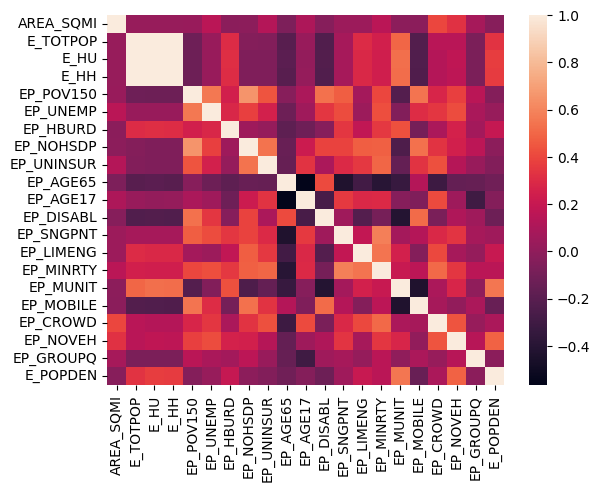

In [128]:
df = pd.read_csv("../SVI2020_US_COUNTY.csv")

# features = ['FIPS', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'E_POV150', 'E_UNEMP', 'E_HBURD', 'E_NOHSDP', 'E_UNINSUR',
#            'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT', 'E_MOBILE', 'E_CROWD',
#            'E_NOVEH', 'E_GROUPQ']

features = ['AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
           'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE',
            'EP_CROWD','EP_NOVEH', 'EP_GROUPQ']

df = df[features]
df['E_POPDEN'] = df['E_TOTPOP'] / df['AREA_SQMI']

pcm = df.corr()
print(pcm)
sns.heatmap(pcm)

selected_features = ['E_TOTPOP', 'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
           'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE',
            'EP_CROWD','EP_NOVEH', 'EP_GROUPQ', 'E_POPDEN']
print(len(selected_features))

In [39]:
# Make geographical adjacency matrix
n = len(columns)
adj = np.ones((n, n))

for i in range(n):
    for j in range(i+1, n):
        if i == j:
            continue
        val = input(f'Is {columns[i]} and {columns[j]} connected? (1 or 0)')
        adj[i, j] = float(val)
        adj[j, i] = float(val)
# np.savetxt(data_path + "/ca_counties-adj.txt", adj)

Is Baldwin and Barrow connected? (1 or 0)a


ValueError: could not convert string to float: 'a'

In [14]:
# Corrections:

adj = np.loadtxt(data_path + "/ca_counties-adj.txt", delimiter=",")
# i = columns.index("Tuolumne")
# j = columns.index("Merced")
print(adj.shape)
print(adj)
# adj[i, j] = 1
# adj[j, i] = 1
adj.astype(int)
# np.savetxt(data_path + "/ca_counties-adj.txt", adj, delimiter=",", fmt="%d")

(51, 51)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1]])

In [81]:
adj = np.loadtxt(data_path + "/ca_counties-adj.txt")
# for i in range(n):
#     print(f'For {columns[i]}:')
#     neighbors = []
#     for j in range(n):
#         if adj[i, j] == 1:
#             neighbors.append(columns[j])
#     print(neighbors)        
print(np.sum(adj))
print(np.sum(np.transpose(adj) - adj))

273.0
0.0


In [61]:
# Visualize the counties on a map
!pip3 install plotly-geo==1.0.0
!pip3 install geopandas==0.3.0
!pip3 install pyshp==1.2.10
!pip3 install shapely==1.6.3

You should consider upgrading via the 'pip install --upgrade pip' command.
^C
ERROR: Operation cancelled by user
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/c0/10/1457c46e20b509108a32a5776141d78d410161dae8ab8da74efe67c530eb/Shapely-1.6.3.tar.gz
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/dt/hfjc42l539z1128c2hk6lms80000gn/T/pip-install-_uu543y9/shapely/setup.py'"'"'; __file__='"'"'/private/var/folders/dt/hfjc42l539z1128c2hk6lms80000gn/T/pip-install-_uu543y9/shapely/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base pip-egg-info

In [4]:
# Get the fips map
import collections
df = pd.read_csv(data_path+"/us-counties.txt")
df = df[df["state"]==state]
df_fips = df[['county', 'fips']].drop_duplicates()
df_fips = df_fips.dropna(axis=0)
fips_map = df_fips.values
county_to_fips = {c: int(f) for c, f in fips_map}
print(county_to_fips)

{'Orange': 6059, 'Los Angeles': 6037, 'Santa Clara': 6085, 'San Francisco': 6075, 'San Diego': 6073, 'Humboldt': 6023, 'Sacramento': 6067, 'Solano': 6095, 'Marin': 6041, 'Napa': 6055, 'Sonoma': 6097, 'Alameda': 6001, 'Placer': 6061, 'San Mateo': 6081, 'Contra Costa': 6013, 'Yolo': 6113, 'Fresno': 6019, 'Madera': 6039, 'Riverside': 6065, 'Santa Cruz': 6087, 'Shasta': 6089, 'San Joaquin': 6077, 'Ventura': 6111, 'Stanislaus': 6099, 'Tulare': 6107, 'San Benito': 6069, 'San Luis Obispo': 6079, 'San Bernardino': 6071, 'Santa Barbara': 6083, 'Nevada': 6057, 'Kern': 6029, 'Monterey': 6053, 'Mendocino': 6045, 'Amador': 6005, 'Imperial': 6025, 'Butte': 6007, 'El Dorado': 6017, 'Siskiyou': 6093, 'Yuba': 6115, 'Calaveras': 6009, 'Merced': 6047, 'Mono': 6051, 'Inyo': 6027, 'Sutter': 6101, 'Colusa': 6011, 'Kings': 6031, 'Glenn': 6021, 'Tuolumne': 6109, 'Alpine': 6003, 'Plumas': 6063, 'Del Norte': 6015, 'Tehama': 6103, 'Lake': 6033, 'Mariposa': 6043, 'Trinity': 6105, 'Sierra': 6091, 'Lassen': 6035, '

In [10]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}